In [1]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import warnings
warnings.filterwarnings('ignore')

## Train and Evaluate a single model

### Setup Parameters

In [2]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

### Load Dataframes

In [3]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

### Initialize DataLoaders

In [4]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

max_ = traindf.Return.max()
min_ = traindf.Return.min()
# traindf = (traindf - min_) / (max_ - min_)
# validdf = (validdf - min_) / (max_ - min_)
# testdf = (testdf - min_) / (max_ - min_)

trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

### Instanciate Model

In [5]:
model = NN.Model(NNtype)
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            200,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)


### Training

In [6]:
model.train(trainloader, validloader)

[00:01] Epoch 1/200 - Train Loss : 1.024441 / Val Loss : 1.011144
[00:33] Epoch 100/200 - Train Loss : 0.941055 / Val Loss : 1.026580
[01:05] Epoch 200/200 - Train Loss : 0.785484 / Val Loss : 1.113167
Train MAE : 0.6461 | Train MAPE  : 2.0125 | Train RSME : 0.7649 | Train Theil-U 0.6387
Valid MAE : 0.8133 | Valid MAPE  : 1.8364 | Valid RSME : 1.1132 | Valid Theil-U 0.7944


### Evaluation

In [7]:
model.evaluate(testloader, testmu, testsigma)

TypeError: can only concatenate list (not "float") to list

In [8]:
model.evaluate_bis(testloader, testmu, testsigma)

Normalized Test MAE : 0.005898 | Test MAPE  : 451.165433 | Test RMSE : 0.000061 | Test Theil-U 0.803371


### PREDICT

(array([  2.,   9.,  36., 121., 101.,  29.,  11.,   7.,   4.,   1.]),
 array([-1.07382941, -0.81056385, -0.54729829, -0.28403273, -0.02076716,
         0.2424984 ,  0.50576396,  0.76902952,  1.03229508,  1.29556065,
         1.55882621]),
 <a list of 10 Patch objects>)

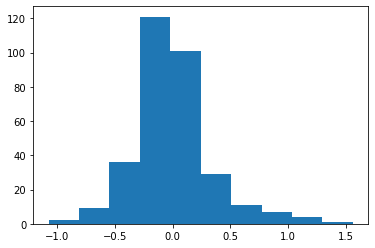

In [9]:
predictions = model.predict(testloader, testmu, testsigma)
plt.hist(np.array(predictions))

RMSE : 0.7258668458497946
MAE : 0.6476853735476763
MAPE : 5.67813688708103
TheilU : 0.7805746498054771


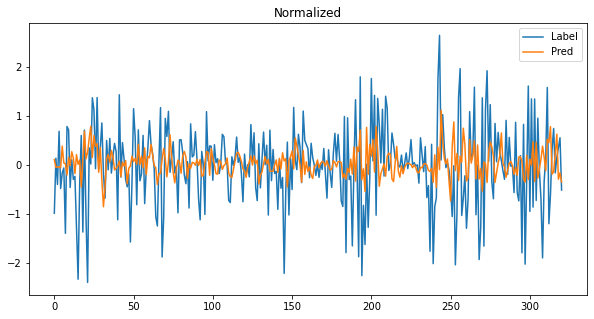

RMSE : 3.834052805885311e-05
MAE : 0.004707221714946177
MAPE : 1.8653901602369747
TheilU : 0.7734055258177408


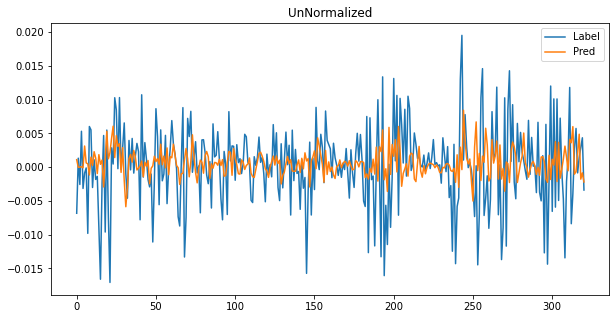

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import torch

preds, targets = [], []
model.model.eval()
with torch.no_grad():
    for features, target in testloader:
        if NNtype == "RNN":
            features = features.view(1, features.size(0), features.size(1))
        outputs = model.model(features)
        preds += outputs.numpy().T.tolist()[0]
        targets += target.numpy().tolist()

preds = np.array(preds)
targets = np.array(targets)

print("RMSE :", mean_squared_error(targets, preds))
print("MAE :", mean_absolute_error(targets, preds))
print("MAPE :", mean_absolute_percentage_error(targets, preds))
print("TheilU :", theilU(targets, preds))

plt.figure(figsize=(10,5))
plt.plot(targets, label="Label")
plt.plot(preds, label="Pred")
plt.title("Normalized")
plt.legend()
plt.show();

preds = np.array(preds)*testsigma + testmu
targets = np.array(targets)*testsigma + testmu

print("RMSE :", mean_squared_error(targets, preds))
print("MAE :", mean_absolute_error(targets, preds))
print("MAPE :", mean_absolute_percentage_error(targets, preds))
print("TheilU :", theilU(targets, preds))

plt.figure(figsize=(10,5))
plt.plot(targets, label="Label")
plt.plot(preds, label="Pred")
plt.title("UnNormalized")
plt.legend();

## Train and Evaluate All Models

In [54]:
ETF = 'SPY'
NNtype = 'PSN'

print("="*10 + ETF + " - " + NNtype + "="*10)
params = cfg.train_parameters[ETF][NNtype]
if ETF == "SPY":
    inputs_lag = cfg.SPYfeatures[NNtype]
elif ETF == "DIA":
    inputs_lag = cfg.DIAfeatures[NNtype]
elif ETF == "QQQ":
    inputs_lag = cfg.QQQfeatures[NNtype]

traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

if NNtype != "PSN":
            
    trainMu, trainSigma = np.mean(traindf.Return.tolist()), np.std(traindf.Return.tolist())
    validMu, validSigma = np.mean(validdf.Return.tolist()), np.std(validdf.Return.tolist())
    testMu, testSigma = np.mean(testdf.Return.tolist()), np.std(testdf.Return.tolist())

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainMu, sigma=trainSigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validMu, sigma=validSigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testMu, sigma=testSigma)

else:
            
    trainMax_, trainMin_ = np.max(traindf.Return.tolist()), np.min(traindf.Return.tolist())
    validMax_, validMin_ = np.max(validdf.Return.tolist()), np.min(validdf.Return.tolist())
    testMax_, testMin_ = np.max(testdf.Return.tolist()), np.min(testdf.Return.tolist())

    traindf = (traindf -  trainMin_) / (trainMax_ - trainMin_)
    validdf = (validdf -  validMin_) / (validMax_ - validMin_)
    testdf = (testdf - testMin_) / (testMax_ - testMin_)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

model = NN.Model(NNtype)
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            500,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

model.train(trainloader, validloader)

==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 0.014703 / Val Loss : 0.020059
[00:35] Epoch 100/500 - Train Loss : 0.012553 / Val Loss : 0.093493
[01:08] Epoch 200/500 - Train Loss : 0.012668 / Val Loss : 0.078937
[01:44] Epoch 300/500 - Train Loss : 0.012942 / Val Loss : 0.074773
[02:18] Epoch 400/500 - Train Loss : 0.370818 / Val Loss : 0.286723
[02:56] Epoch 500/500 - Train Loss : 0.370818 / Val Loss : 0.286723
Train MAE : 0.6000 | Train MAPE  : 1.0000 | Train RSME : 0.3708 | Train Theil-U 1.0000
Valid MAE : 0.5172 | Valid MAPE  : 0.9962 | Valid RSME : 0.2867 | Valid Theil-U 0.8540


Test MAE : 0.023023 | Test MAPE  : 18.303187 | Test RMSE : 0.000584 | Test Theil-U 0.800256


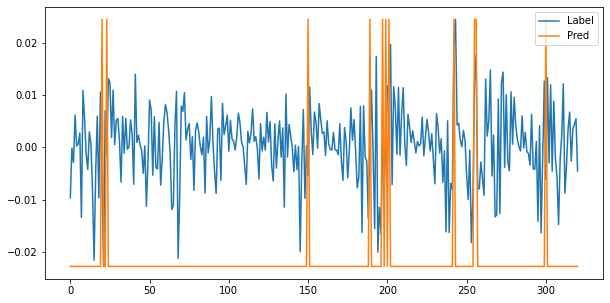

In [55]:
preds = model.predict(testloader, testMu, testSigma)
labels = testdf['Target'].to_list()

if NNtype != "PSN":
    labels = testSigma * np.array(labels) + testMu
    preds = testSigma * np.array(preds) + testMu
else :
    labels = (testMax_ - testMin_) * np.array(labels) + testMin_
    preds = (testMax_ - testMin_) * np.array(preds) + testMin_

testRMSE = mean_squared_error(labels, preds)
testMAE = mean_absolute_error(labels, preds)
testMAPE = mean_absolute_percentage_error(labels, preds)
testTheilU = theilU(labels, preds)

print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

plt.figure(figsize=(10,5))
plt.plot(labels, label="Label")
plt.plot(preds, label="Pred")
plt.legend()
plt.show()


Test MAE : 0.006252 | Test MAPE  : 2.300181 | Test RMSE : 0.000068 | Test Theil-U 0.709301


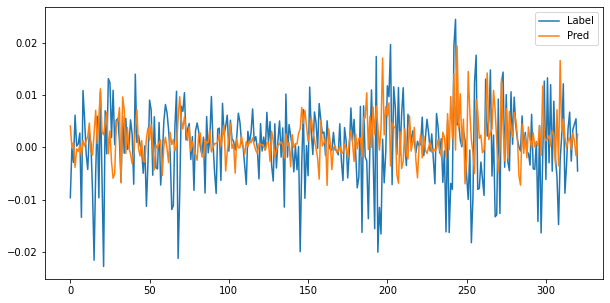

In [52]:
preds = model.predict(testloader, testMu, testSigma)
labels = np.array(testdf['Target'].to_list())

if NNtype != "PSN":
#     labels = testSigma * np.array(labels) + testMu
    preds = testSigma * np.array(preds) + testMu
else :
#     labels = (testMax_ - testMin_) * np.array(labels) + testMin_
    preds = (testMax_ - testMin_) * np.array(preds) + testMin_

testRMSE = mean_squared_error(labels, preds)
testMAE = mean_absolute_error(labels, preds)
testMAPE = mean_absolute_percentage_error(labels, preds)
testTheilU = theilU(labels, preds)

print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

plt.figure(figsize=(10,5))
plt.plot(labels, label="Label")
plt.plot(preds, label="Pred")
plt.legend()
plt.show()


==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.030717 / Val Loss : 1.008842
[00:31] Epoch 100/500 - Train Loss : 0.917211 / Val Loss : 0.996876
[01:04] Epoch 200/500 - Train Loss : 0.871207 / Val Loss : 1.067936
[01:37] Epoch 300/500 - Train Loss : 0.812230 / Val Loss : 1.154431
[02:12] Epoch 400/500 - Train Loss : 0.793453 / Val Loss : 1.210555
[02:48] Epoch 500/500 - Train Loss : 0.766711 / Val Loss : 1.252959
Train MAE : 0.6386 | Train MAPE  : 2.8774 | Train RSME : 0.7515 | Train Theil-U 0.5795
Valid MAE : 0.8701 | Valid MAPE  : 1.8660 | Valid RSME : 1.2530 | Valid Theil-U 0.7326
Test MAE : 0.006453 | Test MAPE  : 2.401972 | Test RMSE : 0.000074 | Test Theil-U 0.712993


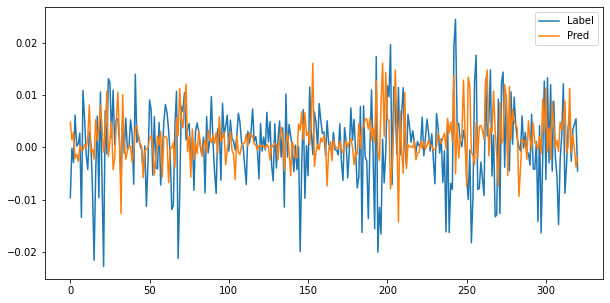




==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.056591 / Val Loss : 0.988218
[00:48] Epoch 100/500 - Train Loss : 0.751974 / Val Loss : 1.146637
[01:43] Epoch 200/500 - Train Loss : 0.729488 / Val Loss : 1.131925
[02:37] Epoch 300/500 - Train Loss : 0.727302 / Val Loss : 1.152053
[03:23] Epoch 400/500 - Train Loss : 0.725111 / Val Loss : 1.160540
[04:12] Epoch 500/500 - Train Loss : 0.723813 / Val Loss : 1.165864
Train MAE : 0.6203 | Train MAPE  : 2.4414 | Train RSME : 0.6983 | Train Theil-U 0.5337
Valid MAE : 0.8394 | Valid MAPE  : 2.1099 | Valid RSME : 1.1659 | Valid Theil-U 0.6848
Test MAE : 0.006407 | Test MAPE  : 2.707877 | Test RMSE : 0.000070 | Test Theil-U 0.717557


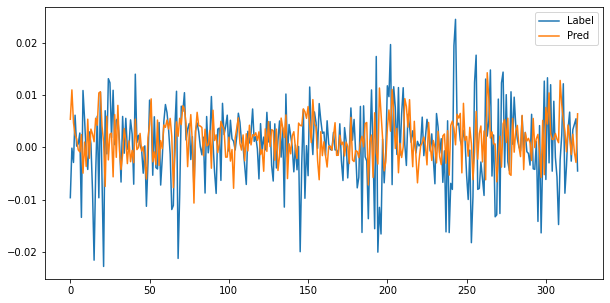




==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 0.014165 / Val Loss : 0.019819
[00:34] Epoch 100/500 - Train Loss : 0.012841 / Val Loss : 0.092723
[01:08] Epoch 200/500 - Train Loss : 0.012636 / Val Loss : 0.085394
[01:42] Epoch 300/500 - Train Loss : 0.012526 / Val Loss : 0.074803
[02:16] Epoch 400/500 - Train Loss : 0.013388 / Val Loss : 0.079415
[02:48] Epoch 500/500 - Train Loss : 0.014985 / Val Loss : 0.027330
Train MAE : 0.0982 | Train MAPE  : 1304.8396 | Train RSME : 0.0170 | Train Theil-U 0.1119
Valid MAE : 0.1266 | Valid MAPE  : 2018.1412 | Valid RSME : 0.0273 | Valid Theil-U 0.1517
Test MAE : 0.489465 | Test MAPE  : 1.232195 | Test RMSE : 0.263865 | Test Theil-U 0.985897


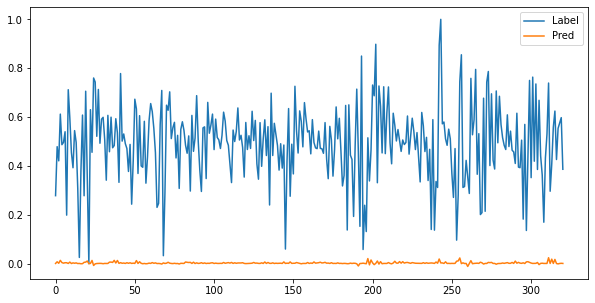




==========DIA - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.004873 / Val Loss : 0.999762
[00:32] Epoch 100/500 - Train Loss : 0.951552 / Val Loss : 1.035471
[01:06] Epoch 200/500 - Train Loss : 0.881312 / Val Loss : 1.072369
[01:38] Epoch 300/500 - Train Loss : 0.792864 / Val Loss : 1.179442
[02:11] Epoch 400/500 - Train Loss : 0.755171 / Val Loss : 1.280852
[02:44] Epoch 500/500 - Train Loss : 0.738806 / Val Loss : 1.324615
Train MAE : 0.6413 | Train MAPE  : 3.1463 | Train RSME : 0.7178 | Train Theil-U 0.5663
Valid MAE : 0.8893 | Valid MAPE  : 2.4409 | Valid RSME : 1.3246 | Valid Theil-U 0.7598
Test MAE : 0.006025 | Test MAPE  : 13.665769 | Test RMSE : 0.000062 | Test Theil-U 0.734166


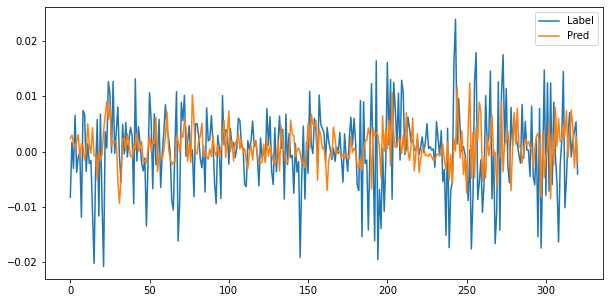




==========DIA - RNN==========
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.054610 / Val Loss : 1.044325
[00:45] Epoch 100/500 - Train Loss : 0.805164 / Val Loss : 1.270724
[01:30] Epoch 200/500 - Train Loss : 0.744554 / Val Loss : 1.340733
[02:15] Epoch 300/500 - Train Loss : 0.728387 / Val Loss : 1.383209
[03:00] Epoch 400/500 - Train Loss : 0.719744 / Val Loss : 1.398562
[03:46] Epoch 500/500 - Train Loss : 0.714755 / Val Loss : 1.412944
Train MAE : 0.6240 | Train MAPE  : 3.4076 | Train RSME : 0.6754 | Train Theil-U 0.5227
Valid MAE : 0.9444 | Valid MAPE  : 2.9018 | Valid RSME : 1.4129 | Valid Theil-U 0.7192
Test MAE : 0.006780 | Test MAPE  : 22.469119 | Test RMSE : 0.000074 | Test Theil-U 0.700858


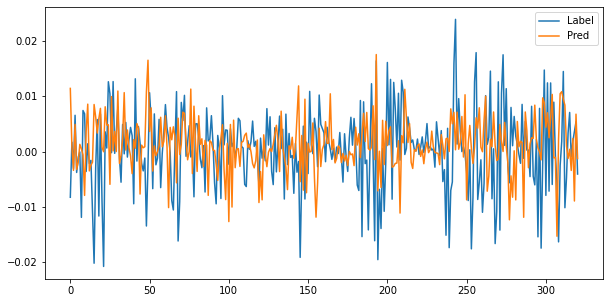




==========DIA - PSN==========
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 0.020692 / Val Loss : 0.018043
[00:31] Epoch 100/500 - Train Loss : 0.013796 / Val Loss : 0.059881
[01:03] Epoch 200/500 - Train Loss : 0.013791 / Val Loss : 0.063021
[01:34] Epoch 300/500 - Train Loss : 0.013442 / Val Loss : 0.059165
[02:06] Epoch 400/500 - Train Loss : 0.012479 / Val Loss : 0.055702
[02:38] Epoch 500/500 - Train Loss : 0.012989 / Val Loss : 0.066635
Train MAE : 0.0902 | Train MAPE  : 737.6766 | Train RSME : 0.0145 | Train Theil-U 0.1037
Valid MAE : 0.1967 | Valid MAPE  : 2311.0048 | Valid RSME : 0.0666 | Valid Theil-U 0.2116
Test MAE : 0.461583 | Test MAPE  : 70.574969 | Test RMSE : 0.239539 | Test Theil-U 0.952711


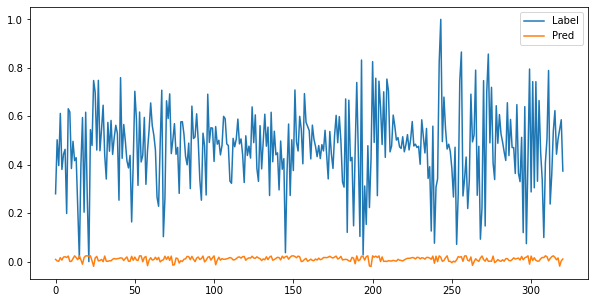




==========QQQ - MLP==========
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.014151 / Val Loss : 0.994976
[00:33] Epoch 100/500 - Train Loss : 0.941773 / Val Loss : 0.986912
[01:06] Epoch 200/500 - Train Loss : 0.797297 / Val Loss : 1.056776
[01:39] Epoch 300/500 - Train Loss : 0.716320 / Val Loss : 1.162682
[02:12] Epoch 400/500 - Train Loss : 0.685530 / Val Loss : 1.230213
[02:45] Epoch 500/500 - Train Loss : 0.674575 / Val Loss : 1.227321
Train MAE : 0.6322 | Train MAPE  : 3.4456 | Train RSME : 0.6458 | Train Theil-U 0.5077
Valid MAE : 0.8516 | Valid MAPE  : 4.7663 | Valid RSME : 1.2273 | Valid Theil-U 0.7143
Test MAE : 0.007864 | Test MAPE  : 19.917973 | Test RMSE : 0.000109 | Test Theil-U 0.753529


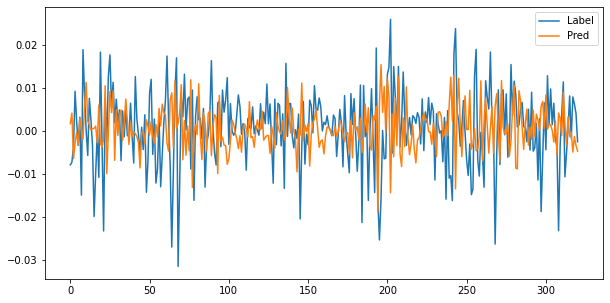




==========QQQ - RNN==========
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.042380 / Val Loss : 1.023453
[00:46] Epoch 100/500 - Train Loss : 0.721916 / Val Loss : 1.355084
[01:32] Epoch 200/500 - Train Loss : 0.630932 / Val Loss : 1.609002
[02:18] Epoch 300/500 - Train Loss : 0.621357 / Val Loss : 1.679477
[03:04] Epoch 400/500 - Train Loss : 0.616473 / Val Loss : 1.700178
[03:57] Epoch 500/500 - Train Loss : 0.613114 / Val Loss : 1.702265
Train MAE : 0.5933 | Train MAPE  : 3.3349 | Train RSME : 0.5957 | Train Theil-U 0.4678
Valid MAE : 1.0169 | Valid MAPE  : 5.3577 | Valid RSME : 1.7023 | Valid Theil-U 0.7435
Test MAE : 0.008459 | Test MAPE  : 21.490425 | Test RMSE : 0.000124 | Test Theil-U 0.745666


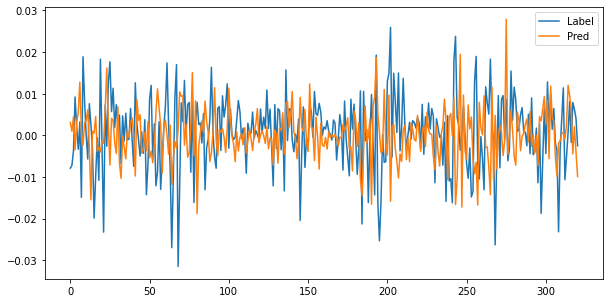




==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 0.018489 / Val Loss : 0.021137
[00:43] Epoch 100/500 - Train Loss : 0.018489 / Val Loss : 0.021137
[01:18] Epoch 200/500 - Train Loss : 0.018489 / Val Loss : 0.021137
[01:52] Epoch 300/500 - Train Loss : 0.014299 / Val Loss : 0.049786
[02:27] Epoch 400/500 - Train Loss : 0.014459 / Val Loss : 0.100999
[03:06] Epoch 500/500 - Train Loss : 0.013946 / Val Loss : 0.120077
Train MAE : 0.0886 | Train MAPE  : 1273.4527 | Train RSME : 0.0136 | Train Theil-U 0.1020
Valid MAE : 0.3016 | Valid MAPE  : 3477.9189 | Valid RSME : 0.1201 | Valid Theil-U 0.2790
Test MAE : 0.558569 | Test MAPE  : 1.718433 | Test RMSE : 0.335254 | Test Theil-U 0.990211


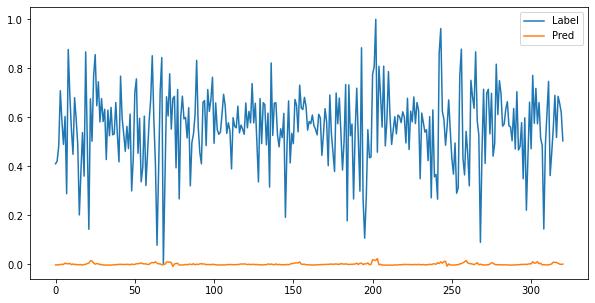

In [53]:
Table4 = pd.DataFrame()

models = {'SPY':{'MLP':None,'RNN':None,'PSN':None},
          'DIA':{'MLP':None,'RNN':None,'PSN':None},
          'QQQ':{'MLP':None,'RNN':None,'PSN':None},
         }

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        print("="*10 + ETF + " - " + NNtype + "="*10)
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        elif ETF == "QQQ":
            inputs_lag = cfg.QQQfeatures[NNtype]

        traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
        validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        if NNtype != "PSN":
            
            trainMu, trainSigma = np.mean(traindf.Return.tolist()), np.std(traindf.Return.tolist())
            validMu, validSigma = np.mean(validdf.Return.tolist()), np.std(validdf.Return.tolist())
            testMu, testSigma = np.mean(testdf.Return.tolist()), np.std(testdf.Return.tolist())

            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainMu, sigma=trainSigma)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validMu, sigma=validSigma)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testMu, sigma=testSigma)

        else:
            
            trainMax_, trainMin_ = np.max(traindf.Return.tolist()), np.min(traindf.Return.tolist())
            validMax_, validMin_ = np.max(validdf.Return.tolist()), np.min(validdf.Return.tolist())
            testMax_, testMin_ = np.max(testdf.Return.tolist()), np.min(testdf.Return.tolist())

            traindf = (traindf -  trainMin_) / (trainMax_ - trainMin_)
            validdf = (validdf -  validMin_) / (validMax_ - validMin_)
            testdf = (testdf - testMin_) / (testMax_ - testMin_)
            
            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)


            
        model = NN.Model(NNtype)
        model.setup(params["input_size"], 
                    params["hidden_size"],
                    params["output_size"],
                    500,#params["epochs"],
                    params["optim"],
                    params["lr"],
                    params["momentum"]
                   )

        model.train(trainloader, validloader)
        #model.evaluate(testloader)
        
        # /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ #
        # /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ #
        preds = model.predict(testloader, testMu, testSigma)
        labels = np.array(testdf['Target'].to_list())
        
        # /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ #
        # /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ /!\ #
        
        if NNtype != "PSN":
#             labels = testSigma * np.array(labels) + testMu
            preds = testSigma * np.array(preds) + testMu
        else :
#             labels = (testMax_ - testMin_) * np.array(labels) + testMin_
            preds = (testMax_ - testMin_) * np.array(preds) + testMin_
        
        testRMSE = mean_squared_error(labels, preds)
        testMAE = mean_absolute_error(labels, preds)
        testMAPE = mean_absolute_percentage_error(labels, preds)
        testTheilU = theilU(labels, preds)

        print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))
        
        plt.figure(figsize=(10,5))
        plt.plot(labels, label="Label")
        plt.plot(preds, label="Pred")
        plt.legend()
        plt.show()
        
        models[ETF][NNtype] = model
        
        Table[NNtype] = [testMAE, testMAPE, testRMSE, testTheilU]
        Table["ETF"] = ETF 
        print("\n"*2)
     
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
# Table4.to_csv("table/Table4norm.csv", index=True) 

### Save Models

In [9]:
for ETF in ["SPY", "DIA", "QQQ"]:
    for NNtype in ["MLP", "RNN", "PSN"]:
        os.makedirs(os.path.join("models_norm", ETF, NNtype), exist_ok=True)
        save_model(models[ETF][NNtype].model.state_dict(), os.path.join("models_norm", ETF, NNtype, "ckpt.pth"))

### Load Ckpt

In [71]:
ETF = "DIA"
NNtype = "MLP"
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            1000,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )
modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Test MAE : 0.005390 | Test MAPE  : 3.646229 | Test RSME : 0.000052 | Test Theil-U 0.926919


# Generating Table 4

In [ ]:
Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader)
        
        Table[NNtype] = [modelloaded.testMAE, modelloaded.testMAPE, modelloaded.testRMSE, modelloaded.testTheilU]
        Table["ETF"] = ETF
    
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True)        

# To work

In [10]:
ypred, ytrue, evaluation = modelloaded.Getevaluation(dataloader)

In [14]:
import numpy as np
y_pred = np.array(ypred)
y_true = np.array(ytrue)

In [51]:
modelloaded.evaluate(dataloader)

Test MAE : 0.005624 | Test MAPE  : inf | Test RSME : 0.000054 | Test Theil-U 0.769070


In [20]:
np.abs((y_true - y_pred)/y_true)

array([5.97504411e-01, 8.19620566e-01, 7.61992324e-01, 1.27961111e+00,
       1.55741931e+00, 1.06965293e+00, 4.08921429e+01, 1.03007374e+00,
       1.17004060e+00, 7.15264093e-01, 6.79977365e-01, 1.38981662e+00,
       5.70637783e-01, 2.21547445e+00, 1.06259083e+00, 8.27917005e-01,
       1.34271908e+00, 1.28133038e+00, 9.69783017e-01, 6.09123871e-01,
       1.31316356e+00, 1.12362061e+00, 4.03105552e-01, 3.35606941e+00,
       7.98431427e-01, 6.87432206e-01, 7.31159248e-01, 3.80845850e-01,
       1.51305376e+00, 1.29509997e+00, 7.20141230e-01, 3.29434595e+00,
       1.13785257e+00, 1.49065573e+00, 3.72291052e+00, 7.72002016e-01,
       6.24651569e-01, 8.43269646e-01, 5.24755104e-01, 1.34105122e+00,
       1.07121130e+00, 9.88006366e-01, 8.68172943e-01, 1.04517050e+00,
       3.42294065e-01, 4.86738036e-01, 1.53935203e+00, 2.25559896e-01,
       8.57544100e-01, 1.52026479e+00, 1.25801378e+00, 6.77532215e-01,
       1.29784225e+00, 7.91556409e-01, 2.08852883e+00, 1.93345424e+00,
      

In [30]:
y_true[y_true == 0] = 0.000006

In [31]:
np.where(y_true == 0)

(array([], dtype=int64),)

In [12]:
Table4

NameError: name 'Table4' is not defined